# Inference and Timing
This notebook goes over how to do inference using the model from torchxrayvision and yolov5m. Additionally, you can use this notebook as a way to assess timings

In [1]:
import torch
import torchxrayvision as xrv
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "" # Comment this for GPU

In [2]:
torch.cuda.is_available()

False

Notice that this pulls weights from the `app/backend/models` folder. Please make sure to follow the prerequisites before continuing on with this notebook.

In [3]:
wgts = '../../app/backend/models/torch_models/yolov5/weights/best.pt'
model_yolo = torch.hub.load('ultralytics/yolov5', 'custom', path=wgts, force_reload=True)
model_xrv = xrv.models.DenseNet(weights='all').cpu() # Remove .cpu() for GPU 

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/fcr/.cache/torch/hub/master.zip
Fusing layers... 
Model Summary: 308 layers, 21090171 parameters, 0 gradients
Adding autoShape... 
YOLOv5 🚀 2021-5-7 torch 1.7.1 CPU



In [4]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [5]:
def load_image_into_numpy_array(path, gray=False):
    if gray:
        img = Image.open(path)
        img = ImageOps.grayscale(img)
        rgbimg = img.resize((224, 224))
    else:
        img = Image.open(path).resize((512, 512))
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
    return np.array(rgbimg), rgbimg

In [6]:
sample, sample_pil = load_image_into_numpy_array(
    '../../examples/example1.jpg'
)

sample_gray, sample_pil_gray = load_image_into_numpy_array(
    '../../examples/example1.jpg',
    gray=True
)

In [7]:
%matplotlib inline

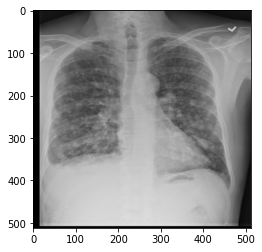

In [8]:
plt.imshow(sample)
plt.show()

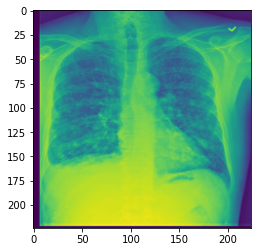

In [9]:
plt.imshow(sample_gray)
plt.show()

In [10]:
sample.shape, sample_gray.shape

((512, 512, 3), (224, 224))

Change the `batch` to whatever you like!

In [30]:
batch = 5
tensor_xrv = torch.from_numpy(np.array([sample_gray[np.newaxis, :]] * batch)).float()
tensor_yolo = [sample] * batch

In [31]:
len(tensor_yolo), tensor_yolo[0].shape, tensor_xrv.shape

(5, (512, 512, 3), torch.Size([5, 1, 224, 224]))

Feel free to comment one of the executions out to see the timings per model. Also edit the `iters` variable to whatever you like!

In [ ]:
from time import time
from tqdm import tqdm

iters = 100

total_time = 0
for _ in tqdm(range(iters), total=iters):
    t1 = time()
    out = model_xrv(tensor_xrv)
    out = model_yolo(tensor_yolo, size=512, augment=True)
    t2 = time()
    total_time += t2 - t1

total_time / iters # Average Time of Batch Inference

 74%|███████▍  | 74/100 [03:17<01:13,  2.82s/it]

In [28]:
iters / total_time # FPS

6.9680783965969

## Results

### XRV
<b>CPU (Suspicious on this CPU Time. Seems similar to GPU)</b>
```
1  images => 00.18 seconds
5  images => 00.65 seconds
10 images => 01.36 seconds
20 images => 02.67 seconds
40 images => 5.24 seconds
```

<b>GPU</b>
```
1  images => 00.14 seconds
5  images => 00.60 seconds
10 images => 01.26 seconds
20 images => 02.34 seconds
40 images => 04.92 seconds
```

### Yolov5m
<b>CPU</b>
```
1  images => 00.52 seconds
5  images => 01.90 seconds
10 images => 03.91 seconds
20 images => 08.77 seconds
40 images => 17.88 seconds
```

<b>GPU</b>
```
1  images => 00.10 seconds
5  images => 00.23 seconds
10 images => 00.52 seconds
20 images => 00.83 seconds
40 images => 01.93 seconds
```

### XRV, then Yolov5m
<b>CPU</b>
```
1  images => 00.68 seconds
5  images => 02.60 seconds
10 images => 05.00 seconds
20 images => 11.19 seconds
40 images => 24.54 seconds
```

<b>GPU</b>
```
1  images => 00.21 seconds
5  images => 00.80 seconds
10 images => 01.48 seconds
20 images => 02.92 seconds
40 images => 06.20 seconds
```